In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import os

In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
DATASET_PATH = '/home/ayagudin/dl/probabilistic-time-series/lobster-preprocessed-dataset/'

In [153]:
from data_utils import load_features_and_targets

In [154]:
features_per_day, targets_per_day = load_features_and_targets(DATASET_PATH)

# Cut session begin & end
> TODO reconstruct dataset so that it will have only moments with huge traded_amount

In [155]:
timestamps_to_cut = 200

In [156]:
for day in features_per_day:
    features_per_day[day] = features_per_day[day][timestamps_to_cut:-timestamps_to_cut]
    targets_per_day[day] = targets_per_day[day][timestamps_to_cut:-timestamps_to_cut].reshape(-1, 1)

In [157]:
full_features = np.concatenate(list(features_per_day.values()))
full_targets = np.concatenate(list(targets_per_day.values()))
full_features.shape, full_targets.shape

((926340, 27), (926340, 1))

# Scaling

In [158]:
from sklearn.preprocessing import StandardScaler

In [159]:
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

In [160]:
feature_scaler.fit(full_features)
target_scaler.fit(full_targets)

StandardScaler()

In [161]:
for day in features_per_day:
    features_per_day[day] = feature_scaler.transform(features_per_day[day])
    targets_per_day[day] = target_scaler.transform(targets_per_day[day]).reshape(-1)

# Defining dataset

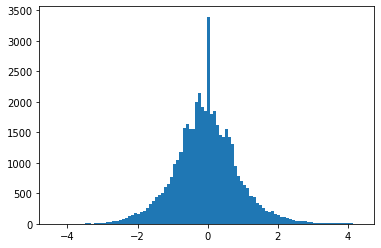

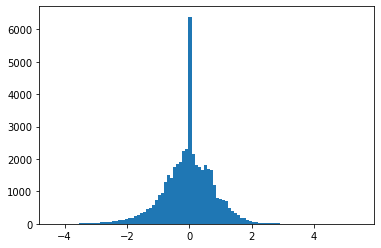

In [162]:
plt.hist(targets_per_day[days[-1]], bins=100);
plt.show()
plt.hist(targets_per_day[days[0]], bins=100);
plt.show()

In [163]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [164]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day]
        }
        for day in train_days
    ],
    freq=dataset_metadata['freq']
)

# for test_ds we had to create a list of dicts 
# with all suffixes from test_days

# MLP Regression

In [166]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer
from gluonts.evaluation import Evaluator

In [167]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=1,
    context_length=10,
    freq=dataset_metadata['freq'],
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [168]:
predictor = estimator.train(train_ds)

100%|██████████████████████████████████████████████| 100/100 [00:05<00:00, 17.37it/s, epoch=5/5, avg_epoch_loss=-1.52]


In [ ]:
# evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

# MLP Uncertainty estimation

In [ ]:
from models.simple_feedforward_network import SimpleFeedForwardNetworkBase